In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import h5py
import pickle
import numpy as np
import torch
import torch_interpolations as torchitp
from torchquad import Simpson, set_up_backend
from scipy.linalg import toeplitz
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import quad,simpson
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')
    
def ytitle(ax,text,xloc=-0.25,**kwargs):
    ax.text(xloc,0.5,text,horizontalalignment='left',verticalalignment='center',
        rotation='vertical',transform=ax.transAxes,**kwargs)

# Interpolate Moments

In [3]:
def μtox(μ):
    return np.sign(μ/100-0.2)*np.abs(μ/100-0.2)**0.5

def xtoμ(x):
    return 100*(np.sign(x)*np.abs(x)**2.0+0.2)
    
def base_itp_moments():
    with open('./../results/itp_ranges'+'.pkl', 'rb') as handle:
        ranges_dict = pickle.load(handle)
    
    φxrange = ranges_dict['Ph']['xrange']
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2])).astype(np.float32)
    φEs = np.load('./../results/PhE_itp.npy').astype(np.float32)
    φIs = np.load('./../results/PhI_itp.npy').astype(np.float32)
    
    Mxrange = ranges_dict['M']['xrange']
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2])).astype(np.float32)
    Mσrange = ranges_dict['M']['σrange']
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2])).astype(np.float32)
    MEs = np.load('./../results/ME_itp.npy').astype(np.float32)
    MIs = np.load('./../results/MI_itp.npy').astype(np.float32)
    
    Cxrange = ranges_dict['C']['xrange']
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2])).astype(np.float32)
    Cσrange = ranges_dict['C']['σrange']
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2])).astype(np.float32)
    Ccrange = ranges_dict['C']['crange']
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2])).astype(np.float32)
    CEs = np.load('./../results/CE_itp.npy').astype(np.float32)
    CIs = np.load('./../results/CI_itp.npy').astype(np.float32)
    
    φE_itp = RegularGridInterpolator((φxs,),φEs,bounds_error=False,fill_value=None)
    φI_itp = RegularGridInterpolator((φxs,),φIs,bounds_error=False,fill_value=None)
    
    ME_itp = RegularGridInterpolator((Mσs,Mxs),MEs,bounds_error=False,fill_value=None)
    MI_itp = RegularGridInterpolator((Mσs,Mxs),MIs,bounds_error=False,fill_value=None)
    
    CE_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CEs,bounds_error=False,fill_value=None)
    CI_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CIs,bounds_error=False,fill_value=None)
    
    def φE(μ):
        try:
            return φE_itp(μtox(1e3*μ)[:,None])
        except:
            return φE_itp([μtox(1e3*μ)])
    def φI(μ):
        try:
            return φI_itp(μtox(1e3*μ)[:,None])
        except:
            return φI_itp([μtox(1e3*μ)])
    
    def ME(μ,Σ):
        return ME_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def MI(μ,Σ):
        return MI_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    def CE(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CE_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    def CI(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CI_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    return φE,φI,ME,MI,CE,CI
    
def opto_itp_moments(L,CVL):
    with open('./../results/itp_ranges'+'.pkl', 'rb') as handle:
        ranges_dict = pickle.load(handle)
    
    φxrange = ranges_dict['PhL']['xrange']
    φxs = np.linspace(φxrange[0],φxrange[1],round(φxrange[2])).astype(np.float32)
    φLs = np.load('./../results/PhL_itp'+'_L={:.2f}'.format(L)+'_CVL={:.2f}'.format(CVL)+'.npy').astype(np.float32)
    
    Mxrange = ranges_dict['ML']['xrange']
    Mxs = np.linspace(Mxrange[0],Mxrange[1],round(Mxrange[2])).astype(np.float32)
    Mσrange = ranges_dict['ML']['σrange']
    Mσs = np.linspace(Mσrange[0],Mσrange[1],round(Mσrange[2])).astype(np.float32)
    MLs = np.load('./../results/ML_itp'+'_L={:.2f}'.format(L)+'_CVL={:.2f}'.format(CVL)+'.npy').astype(np.float32)
    
    Cxrange = ranges_dict['CL']['xrange']
    Cxs = np.linspace(Cxrange[0],Cxrange[1],round(Cxrange[2])).astype(np.float32)
    Cσrange = ranges_dict['CL']['σrange']
    Cσs = np.linspace(Cσrange[0],Cσrange[1],round(Cσrange[2])).astype(np.float32)
    Ccrange = ranges_dict['CL']['crange']
    Ccs = np.linspace(Ccrange[0],Ccrange[1],round(Ccrange[2])).astype(np.float32)
    CLs = np.load('./../results/CL_itp'+'_L={:.2f}'.format(L)+'_CVL={:.2f}'.format(CVL)+'.npy').astype(np.float32)
    
    φL_itp = RegularGridInterpolator((φxs,),φLs,bounds_error=False,fill_value=None)
    
    ML_itp = RegularGridInterpolator((Mσs,Mxs),MLs,bounds_error=False,fill_value=None)
    
    CL_itp = RegularGridInterpolator((Ccs,Cσs,Cxs),CLs,bounds_error=False,fill_value=None)
    
    def φL(μ):
        try:
            return φL_itp(μtox(1e3*μ)[:,None])
        except:
            return φL_itp([μtox(1e3*μ)])
    
    def ML(μ,Σ):
        return ML_itp(np.row_stack(list(np.broadcast(1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    def CL(μ,Σ,k):
        c = np.sign(k)*np.fmin(np.abs(k)/Σ,1)
        return CL_itp(np.row_stack(list(np.broadcast(c,1e3*np.sqrt(Σ),μtox(1e3*μ)))))
    
    return φL,ML,CL

# Define First Stage Ring DMFT Functions

In [50]:
def doub_vec(A):
    return np.concatenate([A,A])

def doub_mat(A):
    return np.block([[A,np.zeros_like(A)],[np.zeros_like(A),A]])

def each_diag(A):
    return np.einsum('ijj->ij',A)

def each_matmul(A,B):
    return np.einsum('ijk,jk->ik',A,B)

def grid_stat(stat,A,Tstat,dt):
    Ntyp = A.shape[0]
    Nsav = A.shape[1]
    Nstat = round(Tstat/dt)+1
    A_ext = np.zeros((Ntyp,Nstat))
    if Nsav < Nstat:
        A_ext[:,:Nsav] = A
        A_ext[:,Nsav:] = A[:,-1:]
    else:
        A_ext = A[:,:Nstat]
    A_mat = np.array([toeplitz(A_ext[typ_idx]) for typ_idx in range(Ntyp)])
    return stat(A_mat,axis=(1,2))

In [5]:
def base_M(μi,Σii,out):
    out[0] = ME(μi[0],Σii[0])[0]
    out[1] = MI(μi[1],Σii[1])[0]

def base_C(μi,Σii,Σij,out):
    out[0] = CE(μi[0],Σii[0],Σij[0])[0]
    out[1] = CI(μi[1],Σii[1],Σij[1])[0]
    
def opto_M(μi,Σii,out):
    out[0] = ML(μi[0],Σii[0])[0]
    out[1] = MI(μi[1],Σii[1])[0]

def opto_C(μi,Σii,Σij,out):
    out[0] = CL(μi[0],Σii[0],Σij[0])[0]
    out[1] = CI(μi[1],Σii[1],Σij[1])[0]

In [6]:
def sparse_dmft(τ,W,K,Hb,Hp,εH,sW,sH,sa,M_fn,C_fn,Twrm,Tsav,dt,
                rb0=None,ra0=None,rp0=None,Crb0=None,Cra0=None,Crp0=None):
    Ntyp = len(Hb)
    Nint = round((Twrm+Tsav)/dt)+1
    Nclc = round(1.5*Tsav/dt)+1
    Nsav = round(Tsav/dt)+1
    
    rb = np.zeros((Ntyp,Nint),dtype=np.float32)
    ra = np.zeros((Ntyp,Nint),dtype=np.float32)
    rp = np.zeros((Ntyp,Nint),dtype=np.float32)
    Crb = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Cra = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Crp = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    
    if rb0 is None:
        rb0 = 1e-8*np.ones((Ntyp),dtype=np.float32)
    if ra0 is None:
        ra0 = 2e-8*np.ones((Ntyp),dtype=np.float32)
    if rp0 is None:
        rp0 = 5e-8*np.ones((Ntyp),dtype=np.float32)
    if Crb0 is None:
        Crb0 = 1e2*np.ones((Ntyp,1),dtype=np.float32)
    if Cra0 is None:
        Cra0 = 4e2*np.ones((Ntyp,1),dtype=np.float32)
    if Crp0 is None:
        Crp0 = 25e2*np.ones((Ntyp,1),dtype=np.float32)
        
    τinv = 1/τ
    dtτinv = dt/τ
    dtτinv2 = dtτinv**2
    
    sa2 = sa**2
    sW2 = sW**2
    sH2 = sH**2
        
    μW = τ[:,None]*W*K
    ΣW = τ[:,None]**2*W**2*K
    
    μHb = τ*Hb
    ΣHb = (μHb*εH)**2
    μHa = τ*(Hb+(Hp-Hb)*np.exp(-0.5*sa2/sH2))
    ΣHa = (μHa*εH)**2
    μHp = τ*Hp
    ΣHp = (μHp*εH)**2
    
    rb[:,0] = rb0
    ra[:,0] = ra0
    rp[:,0] = rp0
    
    NCr0 = Crb0.shape[1]
    if Nclc > NCr0:
        Crb[:,0,:NCr0] = Crb0
        Crb[:,0,NCr0:Nclc] = Crb0[:,-1:]
        Crb[:,:NCr0,0] = Crb0
        Crb[:,NCr0:Nclc,0] = Crb0[:,-1:]
        
        Cra[:,0,:NCr0] = Cra0
        Cra[:,0,NCr0:Nclc] = Cra0[:,-1:]
        Cra[:,:NCr0,0] = Cra0
        Cra[:,NCr0:Nclc,0] = Cra0[:,-1:]
        
        Crp[:,0,:NCr0] = Crp0
        Crp[:,0,NCr0:Nclc] = Crp0[:,-1:]
        Crp[:,:NCr0,0] = Crp0
        Crp[:,NCr0:Nclc,0] = Crp0[:,-1:]
    else:
        Crb[:,0,:Nclc] = Crb0[:,:Nclc]
        Crb[:,:Nclc,0] = Crb0[:,:Nclc]
        
        Cra[:,0,:Nclc] = Cra0[:,:Nclc]
        Cra[:,:Nclc,0] = Cra0[:,:Nclc]
        
        Crp[:,0,:Nclc] = Crp0[:,:Nclc]
        Crp[:,:Nclc,0] = Crp0[:,:Nclc]
        
    Mφb = np.empty((Ntyp),dtype=np.float32)
    Mφa = np.empty((Ntyp),dtype=np.float32)
    Mφp = np.empty((Ntyp),dtype=np.float32)
    Cφb = np.empty((Ntyp),dtype=np.float32)
    Cφa = np.empty((Ntyp),dtype=np.float32)
    Cφp = np.empty((Ntyp),dtype=np.float32)
    
    for i in range(Nint-1):
        rbi = rb[:,i]
        rai = ra[:,i]
        rpi = rp[:,i]
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        Crbii = Crb[:,i,i]
        Craii = Cra[:,i,i]
        Crpii = Crp[:,i,i]
        sCr2ii = 0.5*sa2/np.log(np.fmax(np.abs((Crpii-Crbii)/(Craii-Crbii)),1+1e-4))
        sWCr2ii = sW2+sCr2ii
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        Σbii = ΣW@Crbii + ΣHb
        Σaii = ((1-np.sqrt(sCr2ii/sWCr2ii)*np.exp(-0.5*sa2/sWCr2ii))*ΣW)@Crbii +\
            (np.sqrt(sCr2ii/sWCr2ii)*np.exp(-0.5*sa2/sWCr2ii)*ΣW)@Crpii + ΣHa
        Σpii = ((1-np.sqrt(sCr2ii/sWCr2ii))*ΣW)@Crbii + (np.sqrt(sCr2ii/sWCr2ii)*ΣW)@Crpii + ΣHp
        M_fn(μbi,Σbii,Mφb)
        M_fn(μai,Σaii,Mφa)
        M_fn(μpi,Σpii,Mφp)
        kb1 = τinv*(-rbi + Mφb)
        ka1 = τinv*(-rai + Mφa)
        kp1 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + 0.5*dt*kb1
        rai = ra[:,i] + 0.5*dt*ka1
        rpi = rp[:,i] + 0.5*dt*kp1
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        M_fn(μbi,Σbii,Mφb)
        M_fn(μai,Σaii,Mφa)
        M_fn(μpi,Σpii,Mφp)
        kb2 = τinv*(-rbi + Mφb)
        ka2 = τinv*(-rai + Mφa)
        kp2 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + 0.5*dt*kb2
        rai = ra[:,i] + 0.5*dt*ka2
        rpi = rp[:,i] + 0.5*dt*kp2
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        M_fn(μbi,Σbii,Mφb)
        M_fn(μai,Σaii,Mφa)
        M_fn(μpi,Σpii,Mφp)
        kb3 = τinv*(-rbi + Mφb)
        ka3 = τinv*(-rai + Mφa)
        kp3 = τinv*(-rpi + Mφp)
        
        rbi = rb[:,i] + dt*kb3
        rai = ra[:,i] + dt*ka3
        rpi = rp[:,i] + dt*kp3
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        M_fn(μbi,Σbii,Mφb)
        M_fn(μai,Σaii,Mφa)
        M_fn(μpi,Σpii,Mφp)
        kb4 = τinv*(-rbi + Mφb)
        ka4 = τinv*(-rai + Mφa)
        kp4 = τinv*(-rpi + Mφp)
        
        rb[:,i+1] = rb[:,i] + dt/6*(kb1+2*kb2+2*kb3+kb4)
        ra[:,i+1] = ra[:,i] + dt/6*(ka1+2*ka2+2*ka3+ka4)
        rp[:,i+1] = rp[:,i] + dt/6*(kp1+2*kp2+2*kp3+kp4)
        rbi = rb[:,i]
        rai = ra[:,i]
        rpi = rp[:,i]
        sr2i = 0.5*sa2/np.log(np.fmax(np.abs((rpi-rbi)/(rai-rbi)),1+1e-4))
        sWr2i = sW2+sr2i
        μbi = μW@rbi + μHb
        μai = ((1-np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i))*μW)@rbi +\
            (np.sqrt(sr2i/sWr2i)*np.exp(-0.5*sa2/sWr2i)*μW)@rpi + μHa
        μpi = ((1-np.sqrt(sr2i/sWr2i))*μW)@rbi + (np.sqrt(sr2i/sWr2i)*μW)@rpi + μHp
        
        if np.any(np.abs(rb[:,i+1]) > 1e10) or np.any(np.isnan(rb[:,i+1])):
            print("system diverged when integrating rb")
            return rb,ra,rp,Crb,Cra,Crp,False,False,False
        if np.any(np.abs(ra[:,i+1]) > 1e10) or np.any(np.isnan(ra[:,i+1])):
            print("system diverged when integrating ra")
            return rb,ra,rp,Crb,Cra,Crp,False,False,False
        if np.any(np.abs(rp[:,i+1]) > 1e10) or np.any(np.isnan(rp[:,i+1])):
            print("system diverged when integrating rp")
            return rb,ra,rp,Crb,Cra,Crp,False,False,False

        if i > Nclc-1:
            Crb[:,i+1,i-Nclc] = Crb[:,i,i-Nclc]
            Cra[:,i+1,i-Nclc] = Cra[:,i,i-Nclc]
            Crp[:,i+1,i-Nclc] = Crp[:,i,i-Nclc]
            
        for j in range(max(0,i-Nclc),i+1):
            Crbij = Crb[:,i,j]
            Craij = Cra[:,i,j]
            Crpij = Crp[:,i,j]
            sCr2ij = 0.5*sa2/np.log(np.fmax(np.abs((Crpij-Crbij)/(Craij-Crbij)),1+1e-4))
            sWCr2ij = sW2+sCr2ij
            Σbij = ΣW@Crbij + ΣHb
            Σaij = ((1-np.sqrt(sCr2ij/sWCr2ij)*np.exp(-0.5*sa2/sWCr2ij))*ΣW)@Crbij +\
                (np.sqrt(sCr2ij/sWCr2ij)*np.exp(-0.5*sa2/sWCr2ij)*ΣW)@Crpij + ΣHa
            Σpij = ((1-np.sqrt(sCr2ij/sWCr2ij))*ΣW)@Crbij + (np.sqrt(sCr2ij/sWCr2ij)*ΣW)@Crpij + ΣHp
            C_fn(μbi,Σbii,Σbij,Cφb)
            C_fn(μai,Σaii,Σaij,Cφa)
            C_fn(μpi,Σpii,Σpij,Cφp)
            Crb[:,i+1,j+1] = Crb[:,i,j+1]+Crb[:,i+1,j]-Crb[:,i,j] +\
                dtτinv*(-Crb[:,i+1,j]-Crb[:,i,j+1]+2*Crb[:,i,j]) + dtτinv2*(-Crb[:,i,j]+Cφb)
            Cra[:,i+1,j+1] = Cra[:,i,j+1]+Cra[:,i+1,j]-Cra[:,i,j] +\
                dtτinv*(-Cra[:,i+1,j]-Cra[:,i,j+1]+2*Cra[:,i,j]) + dtτinv2*(-Cra[:,i,j]+Cφa)
            Crp[:,i+1,j+1] = Crp[:,i,j+1]+Crp[:,i+1,j]-Crp[:,i,j] +\
                dtτinv*(-Crp[:,i+1,j]-Crp[:,i,j+1]+2*Crp[:,i,j]) + dtτinv2*(-Crp[:,i,j]+Cφp)
            
            if np.any(np.abs(Crb[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Crb[:,i+1,j+1])):
                print("system diverged when integrating Crb")
                return rb,ra,rp,Crb,Cra,Crp,False,False,False
            if np.any(np.abs(Cra[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Cra[:,i+1,j+1])):
                print("system diverged when integrating Cra")
                return rb,ra,rp,Crb,Cra,Crp,False,False,False
            if np.any(np.abs(Crp[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Crp[:,i+1,j+1])):
                print("system diverged when integrating Crp")
                return rb,ra,rp,Crb,Cra,Crp,False,False,False
                
            Crb[:,j+1,i+1] = Crb[:,i+1,j+1]
            Cra[:,j+1,i+1] = Cra[:,i+1,j+1]
            Crp[:,j+1,i+1] = Crp[:,i+1,j+1]
            
        Ndiv = 5
        if (Ndiv*(i+1)) % (Nint-1) == 0:
            print("{:.2f}% completed".format((i+1)/(Nint-1)))
            
    Crb_diag = each_diag(Crb)
    Cra_diag = each_diag(Cra)
    Crp_diag = each_diag(Crp)
    
    return rb,ra,rp,Crb,Cra,Crp,\
        (np.max(Crb_diag[:,-Nsav:],axis=1)-np.min(Crb_diag[:,-Nsav:],axis=1))/\
            np.mean(Crb_diag[:,-Nsav:],axis=1) < 1e-3,\
        (np.max(Cra_diag[:,-Nsav:],axis=1)-np.min(Cra_diag[:,-Nsav:],axis=1))/\
            np.mean(Cra_diag[:,-Nsav:],axis=1) < 1e-3,\
        (np.max(Crp_diag[:,-Nsav:],axis=1)-np.min(Crp_diag[:,-Nsav:],axis=1))/\
            np.mean(Crp_diag[:,-Nsav:],axis=1) < 1e-3

def doub_sparse_dmft(τ,W,K,Hb,Hp,εH,sW,sH,sa,M_fns,C_fns,Twrm,Tsav,dt,
                     rb0=None,ra0=None,rp0=None,Crb0=None,Cra0=None,Crp0=None):
    Ntyp = len(Hb)
    
    doub_τ = doub_vec(τ)
    doub_W = doub_mat(W)
    doub_K = doub_vec(K)
    doub_Hb = doub_vec(Hb)
    doub_Hp = doub_vec(Hp)
    doub_sW = doub_mat(sW)
    doub_sH = doub_vec(sH)
    
    def doub_M(μi,Σii,out):
        M_fns[0](μi[:Ntyp],Σii[:Ntyp],out[:Ntyp])
        M_fns[1](μi[Ntyp:],Σii[Ntyp:],out[Ntyp:])
        
    def doub_C(μi,Σii,Σij,out):
        C_fns[0](μi[:Ntyp],Σii[:Ntyp],Σij[:Ntyp],out[:Ntyp])
        C_fns[1](μi[Ntyp:],Σii[Ntyp:],Σij[Ntyp:],out[Ntyp:])
        
    return sparse_dmft(doub_τ,doub_W,doub_K,doub_Hb,doub_Hp,εH,doub_sW,doub_sH,sa,doub_M,doub_C,Twrm,Tsav,dt,
                      rb0,ra0,rp0,Crb0,Cra0,Crp0)

# Get Best Monkey Fit on Ring, Run First Stage DMFT

In [7]:
id = (133, 0)
with open('./../results/results_ring_'+str(id[0])+'.pkl', 'rb') as handle:
    res_dict = pickle.load(handle)[id[1]]
    prms = res_dict['prms']
    eX = res_dict['best_monk_eX']
    bX = res_dict['best_monk_bX']
    aXs = res_dict['best_monk_aXs']
    K = prms['K']
    SoriE = prms['SoriE']
    SoriI = prms['SoriI']
    SoriF = prms['SoriF']
    J = prms['J']
    beta = prms['beta']
    gE = prms['gE']
    gI = prms['gI']
    hE = prms['hE']
    hI = prms['hI']
    L = prms['L']
    CVL = prms['CVL']
    
φE,φI,ME,MI,CE,CI = base_itp_moments()
φL,ML,CL = opto_itp_moments(L,CVL)

τ = np.array([0.02,0.01],dtype=np.float32)
W = J*np.array([[1,-gE],[1./beta,-gI/beta]],dtype=np.float32)
Ks = np.array([K,K/4],dtype=np.float32)
Hb = bX*K*J*np.array([hE,hI/beta],dtype=np.float32)
Hp = (bX+aXs[-1])*K*J*np.array([hE,hI/beta],dtype=np.float32)
εH = eX
sW = np.array([[SoriE,SoriI],[SoriE,SoriI]],dtype=np.float32)
sH = np.array([SoriF,SoriF],dtype=np.float32)
sa = 15
    
sa2 = sa**2
sW2 = sW**2
sH2 = sH**2

μW = τ[:,None]*W*Ks
ΣW = τ[:,None]**2*W**2*Ks

μHb = τ*Hb
ΣHb = (μHb*εH)**2

Twrm = 0.75
Tsav = 0.25
dt = 0.01/4
Nsav = round(Tsav/dt)+1

In [8]:
full_rb,full_ra,full_rp,full_Crb,full_Cra,full_Crp,\
    convb,conva,convp = doub_sparse_dmft(τ,W,Ks,Hb,Hp,εH,sW,sH,sa,[base_M,opto_M],[base_C,opto_C],Twrm,Tsav,dt)

rb = full_rb[:,-1]
ra = full_ra[:,-1]
rp = full_rp[:,-1]
Crb = full_Crb[:,-1,-1:-Nsav-1:-1]
Cra = full_Cra[:,-1,-1:-Nsav-1:-1]
Crp = full_Crp[:,-1,-1:-Nsav-1:-1]

sr2 = 0.5*sa2/np.log(np.fmax(np.abs((rp-rb)/(ra-rb)),1+1e-4))
sCr2 = 0.5*sa2/np.log(np.fmax(np.abs((Crp-Crb)/(Cra-Crb)),1+1e-4))

sr = np.sqrt(sr2)
sCr = np.sqrt(sCr2)

0.20% completed


/var/folders/sm/hlw5tfpd0p385cm1782mwjmh0000gq/T/ipykernel_43272/721867690.py:189: RuntimeWarning: invalid value encountered in true_divide
  sCr2ij = 0.5*sa2/np.log(np.fmax(np.abs((Crpij-Crbij)/(Craij-Crbij)),1+1e-4))


0.40% completed
0.60% completed
0.80% completed
1.00% completed


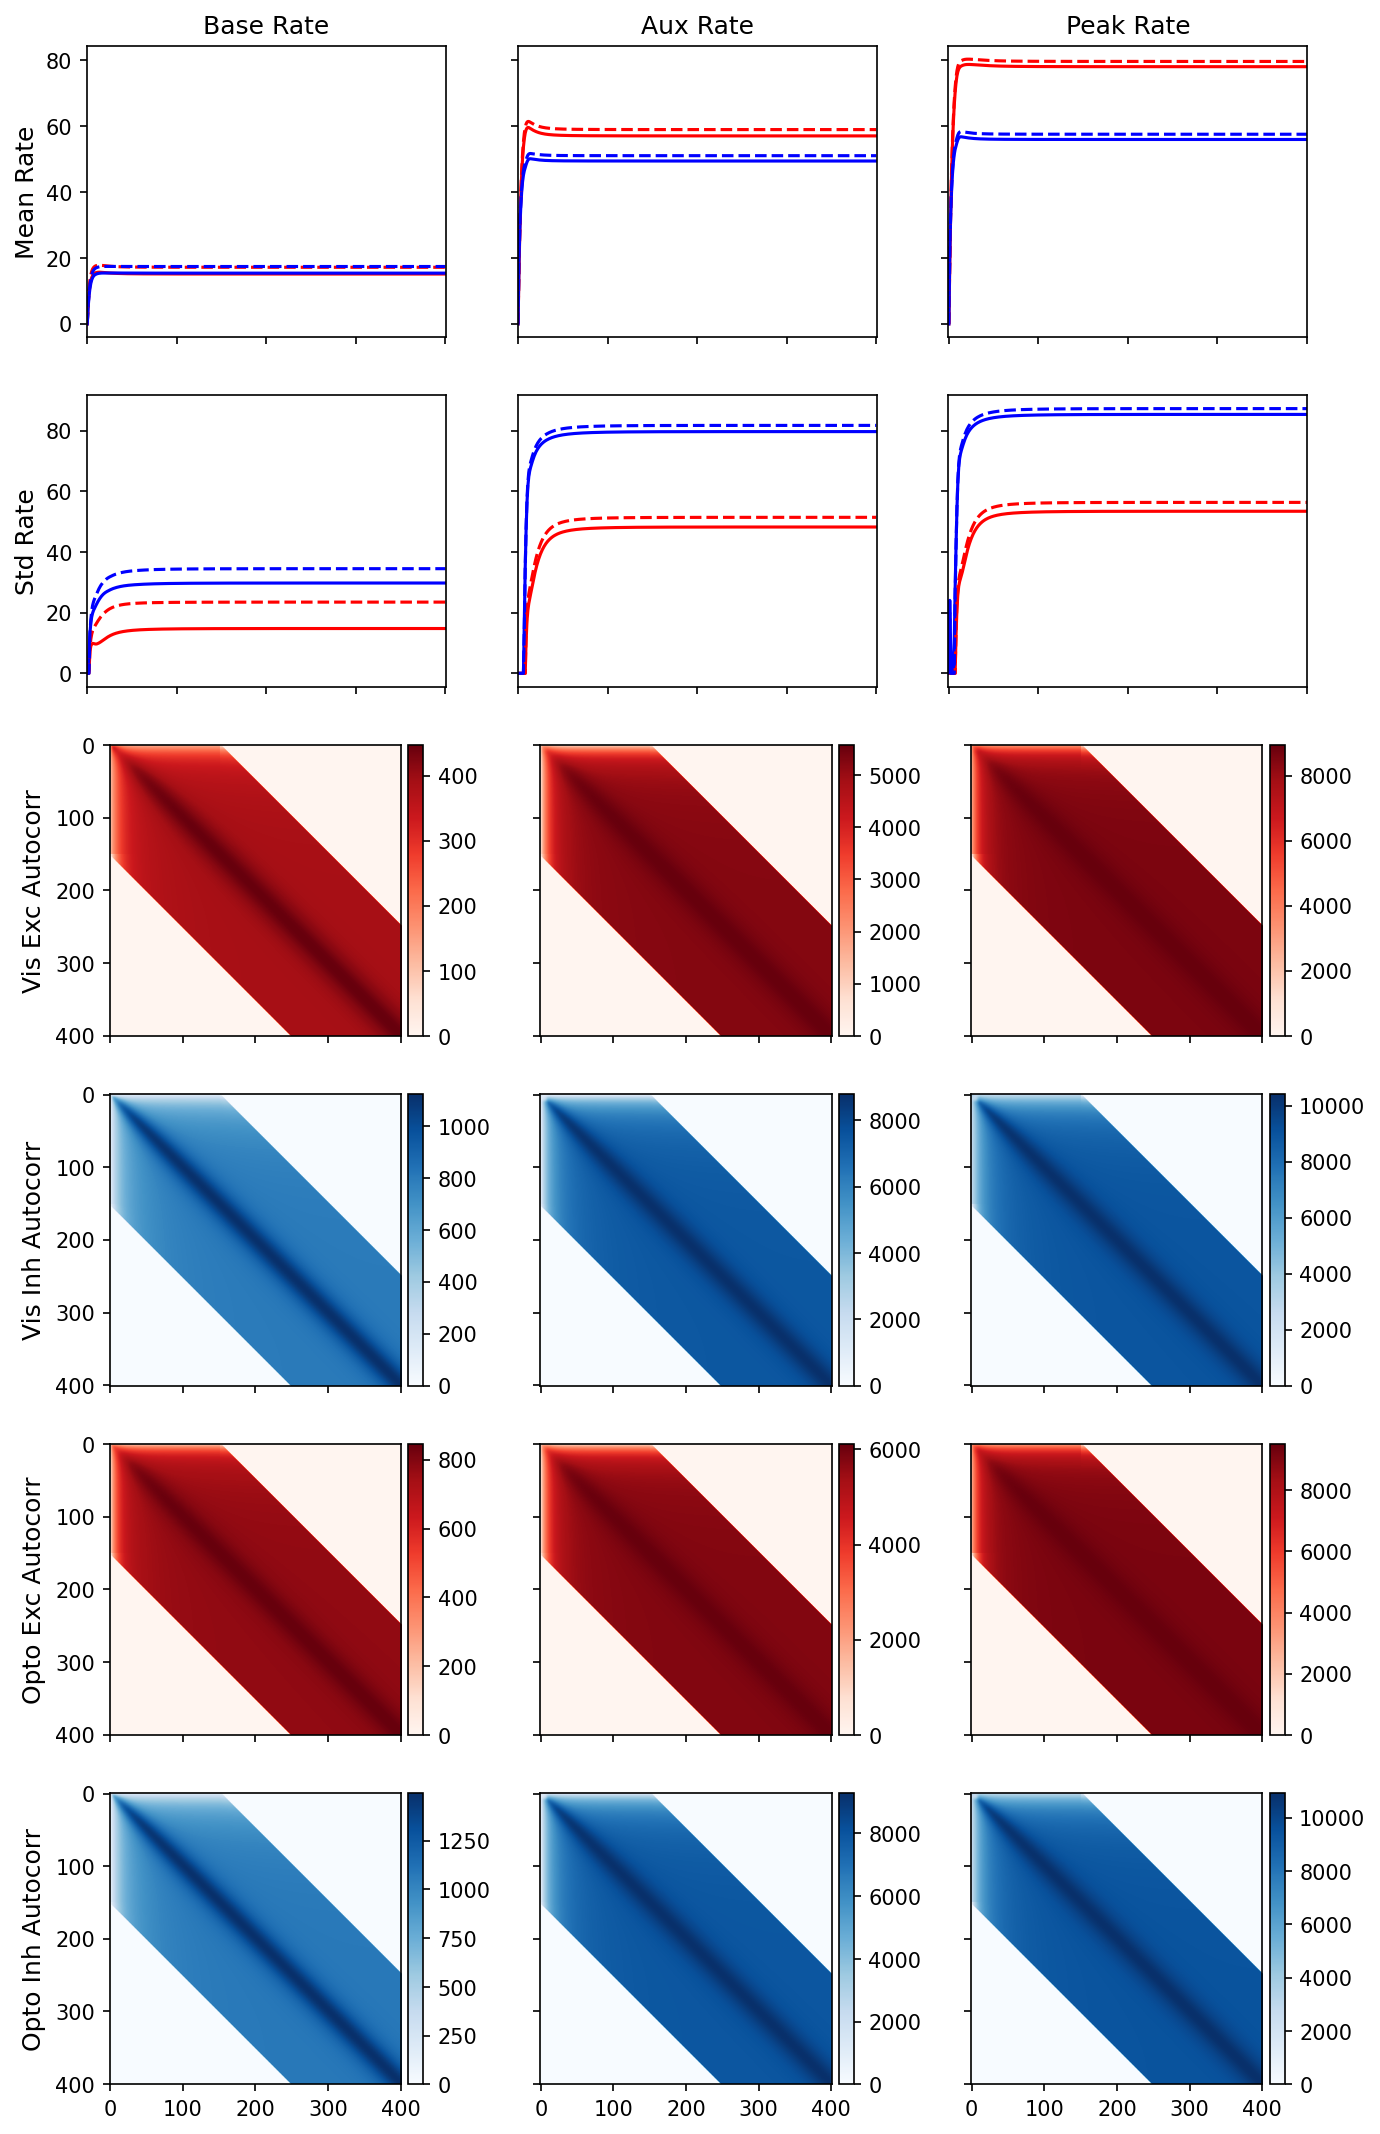

In [13]:
fig,axs = plt.subplots(6,3,figsize=(3.5*3,3*6),dpi=150,sharex=True,sharey='row')

axs[0,0].plot(full_rb[0],'r-')
axs[0,0].plot(full_rb[1],'b-')
axs[0,0].plot(full_rb[2],'r--')
axs[0,0].plot(full_rb[3],'b--')
axs[0,1].plot(full_ra[0],'r-')
axs[0,1].plot(full_ra[1],'b-')
axs[0,1].plot(full_ra[2],'r--')
axs[0,1].plot(full_ra[3],'b--')
axs[0,2].plot(full_rp[0],'r-')
axs[0,2].plot(full_rp[1],'b-')
axs[0,2].plot(full_rp[2],'r--')
axs[0,2].plot(full_rp[3],'b--')

axs[1,0].plot(np.sqrt(np.fmax(np.diag(full_Crb[0])-rb[0]**2,0)),'r-')
axs[1,0].plot(np.sqrt(np.fmax(np.diag(full_Crb[1])-rb[1]**2,0)),'b-')
axs[1,0].plot(np.sqrt(np.fmax(np.diag(full_Crb[2])-rb[2]**2,0)),'r--')
axs[1,0].plot(np.sqrt(np.fmax(np.diag(full_Crb[3])-rb[3]**2,0)),'b--')
axs[1,1].plot(np.sqrt(np.fmax(np.diag(full_Cra[0])-ra[0]**2,0)),'r-')
axs[1,1].plot(np.sqrt(np.fmax(np.diag(full_Cra[1])-ra[1]**2,0)),'b-')
axs[1,1].plot(np.sqrt(np.fmax(np.diag(full_Cra[2])-ra[2]**2,0)),'r--')
axs[1,1].plot(np.sqrt(np.fmax(np.diag(full_Cra[3])-ra[3]**2,0)),'b--')
axs[1,2].plot(np.sqrt(np.fmax(np.diag(full_Crp[0])-rp[0]**2,0)),'r-')
axs[1,2].plot(np.sqrt(np.fmax(np.diag(full_Crp[1])-rp[1]**2,0)),'b-')
axs[1,2].plot(np.sqrt(np.fmax(np.diag(full_Crp[2])-rp[2]**2,0)),'r--')
axs[1,2].plot(np.sqrt(np.fmax(np.diag(full_Crp[3])-rp[3]**2,0)),'b--')

imshowbar(fig,axs[2+0,0],full_Crb[0],cmap='Reds')
imshowbar(fig,axs[2+1,0],full_Crb[1],cmap='Blues')
imshowbar(fig,axs[2+2,0],full_Crb[2],cmap='Reds')
imshowbar(fig,axs[2+3,0],full_Crb[3],cmap='Blues')
imshowbar(fig,axs[2+0,1],full_Cra[0],cmap='Reds')
imshowbar(fig,axs[2+1,1],full_Cra[1],cmap='Blues')
imshowbar(fig,axs[2+2,1],full_Cra[2],cmap='Reds')
imshowbar(fig,axs[2+3,1],full_Cra[3],cmap='Blues')
imshowbar(fig,axs[2+0,2],full_Crp[0],cmap='Reds')
imshowbar(fig,axs[2+1,2],full_Crp[1],cmap='Blues')
imshowbar(fig,axs[2+2,2],full_Crp[2],cmap='Reds')
imshowbar(fig,axs[2+3,2],full_Crp[3],cmap='Blues')

axs[0,0].set_title('Base Rate')
axs[0,1].set_title('Aux Rate')
axs[0,2].set_title('Peak Rate')

ytitle(axs[0,0],'Mean Rate',xloc=-0.2,fontsize=12)
ytitle(axs[1,0],'Std Rate',xloc=-0.2,fontsize=12)
ytitle(axs[2+0,0],'Vis Exc Autocorr',xloc=-0.3,fontsize=12)
ytitle(axs[2+1,0],'Vis Inh Autocorr',xloc=-0.3,fontsize=12)
ytitle(axs[2+2,0],'Opto Exc Autocorr',xloc=-0.3,fontsize=12)
ytitle(axs[2+3,0],'Opto Inh Autocorr',xloc=-0.3,fontsize=12)

In [10]:
print(rb)
print(ra)
print(rp)
print(grid_stat(np.mean,Crb,1,dt))
print(grid_stat(np.mean,Cra,1,dt))
print(grid_stat(np.mean,Crp,1,dt))
print(sr)
print(grid_stat(np.mean,sCr,1,dt))
print(convb)
print(conva)
print(convp)

[15.133091 15.398537 17.173674 17.412464]
[57.029774 49.412296 58.94782  51.030403]
[78.02709  55.947884 79.6198   57.536846]
[ 395.23740578  837.91704739  782.81015023 1124.22663635]
[5284.373793   7619.53704258 5824.08001675 8088.80039918]
[8604.41703812 9121.81192323 9177.88571553 9616.18620307]
[16.641127 25.300146 16.72819  25.216362]
[14.73328116 23.70740932 14.85203267 23.81634354]
[ True  True  True  True]
[ True  True  True  True]
[ True  True  True  True]


# Define Second Stage DMFT Functions

In [124]:
sr2π = np.sqrt(2*np.pi)

def R(Μ1,Μ2,μ1,μ2,Σ1,Σ2,k):
    c = np.sign(k)*np.fmin(np.abs(k)/np.sqrt(Σ1*Σ2),1)
    σ1 = np.sign(c)*np.sqrt(Σ1*np.abs(c))
    σ2 = np.sqrt(Σ2*np.abs(c))
    Δ1 = Σ1*(1-np.abs(c))
    Δ2 = Σ2*(1-np.abs(c))
    return quad(lambda x: np.exp(-0.5*x**2)/sr2π*\
                Μ1(μ1+σ1*x,Δ1)*\
                Μ2(μ2+σ2*x,Δ2),-8,8)[0]

def R_int(Μ1,Μ2,μ1,μ2,Σ1,Σ2,k,x):
    c = np.sign(k)*np.fmin(np.abs(k)/np.sqrt(Σ1*Σ2),1)
    σ1 = np.sign(c)*np.sqrt(Σ1*np.abs(c))
    σ2 = np.sqrt(Σ2*np.abs(c))
    Δ1 = Σ1*(1-np.abs(c))
    Δ2 = Σ2*(1-np.abs(c))
    return np.exp(-0.5*x**2)/sr2π*\
                Μ1(μ1+σ1*x,Δ1)*\
                Μ2(μ2+σ2*x,Δ2)

def R_simp(Μ1,Μ2,μ1,μ2,Σ1,Σ2,k):
    c = np.sign(k)*np.fmin(np.abs(k)/np.sqrt(Σ1*Σ2),1)
    σ1 = np.sign(c)*np.sqrt(Σ1*np.abs(c))
    σ2 = np.sqrt(Σ2*np.abs(c))
    Δ1 = Σ1*(1-np.abs(c))
    Δ2 = Σ2*(1-np.abs(c))
    xs = np.linspace(-8,8,1001)
    return simpson(R_int(Μ1,Μ2,μ1,μ2,Σ1,Σ2,k,xs),xs)

def diff_R(μ1i,μ2i,Σ1ii,Σ2ii,kij,out):
    out[0] = R_simp(ME,ML,μ1i[0],μ2i[0],Σ1ii[0],Σ2ii[0],kij[0])
    out[1] = R_simp(MI,MI,μ1i[1],μ2i[1],Σ1ii[1],Σ2ii[1],kij[1])

In [94]:
def diff_sparse_dmft(τ,W,K,Hb,Hp,εH,sW,sH,sa,R_fn,Twrm,Tsav,dt,rb,ra,rp,Crb,Cra,Crp,
                     Cdrb0=None,Cdra0=None,Cdrp0=None):
    Ntyp = len(Hb)
    Nint = round((Twrm+Tsav)/dt)+1
    Nclc = round(1.5*Tsav/dt)+1
    Nsav = round(Tsav/dt)+1
    
    Cdrb = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Cdra = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    Cdrp = np.zeros((Ntyp,Nint,Nint),dtype=np.float32)
    
    if Cdrb0 is None:
        Cdrb0 = (rb[Ntyp:] - rb[:Ntyp]).astype(np.float32)[:,None]**2 + 1e2
    if Cdra0 is None:
        Cdra0 = (ra[Ntyp:] - ra[:Ntyp]).astype(np.float32)[:,None]**2 + 4e2
    if Cdrp0 is None:
        Cdrp0 = (rp[Ntyp:] - rp[:Ntyp]).astype(np.float32)[:,None]**2 + 9e2
        
    τinv = 1/τ
    dtτinv = dt/τ
    dtτinv2 = dtτinv**2
    
    sa2 = sa**2
    sW2 = sW**2
    sH2 = sH**2
        
    μW = τ[:,None]*W*K
    ΣW = τ[:,None]**2*W**2*K
    
    μHb = τ*Hb
    ΣHb = (μHb*εH)**2
    μHa = τ*(Hb+(Hp-Hb)*np.exp(-0.5*sa2/sH2))
    ΣHa = (μHa*εH)**2
    μHp = τ*Hp
    ΣHp = (μHp*εH)**2
    
    doub_μW = doub_mat(μW)
    doub_ΣW = doub_mat(ΣW)
    
    sr2 = 0.5*sa2/np.log(np.fmax(np.abs((rp-rb)/(ra-rb)),1+1e-4))
    sWr2 = doub_mat(sW2)+sr2
    sCr2 = 0.5*sa2/np.log(np.fmax(np.abs((Crp-Crb)/(Cra-Crb)),1+1e-4))
    sWCr2 = doub_mat(sW2)[:,:,None]+sCr2[None,:,:]
    μb = doub_μW@rb + doub_vec(μHb)
    μa = ((1-np.sqrt(sr2/sWr2)*np.exp(-0.5*sa2/sWr2))*doub_μW)@rb +\
        (np.sqrt(sr2/sWr2)*np.exp(-0.5*sa2/sWr2)*doub_μW)@rp + doub_vec(μHa)
    μp = ((1-np.sqrt(sr2/sWr2))*doub_μW)@rb + (np.sqrt(sr2/sWr2)*doub_μW)@rp + doub_vec(μHp)
    Σb = doub_ΣW@Crb + doub_vec(ΣHb)[:,None]
    Σa = each_matmul((1-np.sqrt(sCr2/sWCr2)*np.exp(-0.5*sa2/sWCr2))*doub_ΣW[:,:,None],Crb) +\
        each_matmul(np.sqrt(sCr2/sWCr2)*np.exp(-0.5*sa2/sWCr2)*doub_ΣW[:,:,None],Crp) + doub_vec(ΣHa)[:,None]
    Σp = each_matmul((1-np.sqrt(sCr2/sWCr2))*doub_ΣW[:,:,None],Crb) +\
        each_matmul(np.sqrt(sCr2/sWCr2)*doub_ΣW[:,:,None],Crp) + doub_vec(ΣHp)[:,None]
    
    NCdr0 = Cdrb0.shape[1]
    if Nclc > NCdr0:
        Cdrb[:,0,:NCdr0] = Cdrb0
        Cdrb[:,0,NCdr0:Nclc] = Cdrb0[:,-1:]
        Cdrb[:,:NCdr0,0] = Cdrb0
        Cdrb[:,NCdr0:Nclc,0] = Cdrb0[:,-1:]
        
        Cdra[:,0,:NCdr0] = Cdra0
        Cdra[:,0,NCdr0:Nclc] = Cdra0[:,-1:]
        Cdra[:,:NCdr0,0] = Cdra0
        Cdra[:,NCdr0:Nclc,0] = Cdra0[:,-1:]
        
        Cdrp[:,0,:NCdr0] = Cdrp0
        Cdrp[:,0,NCdr0:Nclc] = Cdrp0[:,-1:]
        Cdrp[:,:NCdr0,0] = Cdrp0
        Cdrp[:,NCdr0:Nclc,0] = Cdrp0[:,-1:]
    else:
        Cdrb[:,0,:Nclc] = Cdrb0[:,:Nclc]
        Cdrb[:,:Nclc,0] = Cdrb0[:,:Nclc]
        
        Cdra[:,0,:Nclc] = Cdra0[:,:Nclc]
        Cdra[:,:Nclc,0] = Cdra0[:,:Nclc]
        
        Cdrp[:,0,:Nclc] = Cdrp0[:,:Nclc]
        Cdrp[:,:Nclc,0] = Cdrp0[:,:Nclc]
        
    Rφb = np.empty((Ntyp),dtype=np.float32)
    Rφa = np.empty((Ntyp),dtype=np.float32)
    Rφp = np.empty((Ntyp),dtype=np.float32)
    
    for i in range(Nint-1):
        if i > Nclc-1:
            Cdrb[:,i+1,i-Nclc] = Cdrb[:,i,i-Nclc]
            Cdra[:,i+1,i-Nclc] = Cdra[:,i,i-Nclc]
            Cdrp[:,i+1,i-Nclc] = Cdrp[:,i,i-Nclc]
            
        for j in range(max(0,i-Nclc),i+1):
            ij_idx = np.fmin(i-j,Nsav-1)
            
            Cdrbij = Cdrb[:,i,j]
            Cdraij = Cdra[:,i,j]
            Cdrpij = Cdrp[:,i,j]
            sCdr2ij = 0.5*sa2/np.log(np.fmax(np.abs((Cdrpij-Cdrbij)/(Cdraij-Cdrbij)),1+1e-4))
            sWCdr2ij = sW2+sCdr2ij
            Σdbij = ΣW@Cdrbij
            Σdaij = ((1-np.sqrt(sCdr2ij/sWCdr2ij)*np.exp(-0.5*sa2/sWCdr2ij))*ΣW)@Cdrbij +\
                (np.sqrt(sCdr2ij/sWCdr2ij)*np.exp(-0.5*sa2/sWCdr2ij)*ΣW)@Cdrpij
            Σdpij = ((1-np.sqrt(sCdr2ij/sWCdr2ij))*ΣW)@Cdrbij + (np.sqrt(sCdr2ij/sWCdr2ij)*ΣW)@Cdrpij
            
            kbij = 0.5*(Σb[:Ntyp,ij_idx]+Σb[Ntyp:,ij_idx]-Σdbij)
            kaij = 0.5*(Σa[:Ntyp,ij_idx]+Σa[Ntyp:,ij_idx]-Σdaij)
            kpij = 0.5*(Σp[:Ntyp,ij_idx]+Σp[Ntyp:,ij_idx]-Σdpij)
            
            R_fn(μb[:Ntyp],μb[Ntyp:],Σb[:Ntyp,0],Σb[Ntyp:,0],kbij,Rφb)
            R_fn(μa[:Ntyp],μa[Ntyp:],Σa[:Ntyp,0],Σa[Ntyp:,0],kaij,Rφa)
            R_fn(μp[:Ntyp],μp[Ntyp:],Σp[:Ntyp,0],Σp[Ntyp:,0],kpij,Rφp)
            
            Cdrb[:,i+1,j+1] = Cdrb[:,i,j+1]+Cdrb[:,i+1,j]-Cdrb[:,i,j] +\
                dtτinv*(-Cdrb[:,i+1,j]-Cdrb[:,i,j+1]+2*Cdrb[:,i,j]) +\
                dtτinv2*(-Cdrb[:,i,j]+Crb[:Ntyp,ij_idx]+Crb[Ntyp:,ij_idx]-2*Rφb)
            Cdra[:,i+1,j+1] = Cdra[:,i,j+1]+Cdra[:,i+1,j]-Cdra[:,i,j] +\
                dtτinv*(-Cdra[:,i+1,j]-Cdra[:,i,j+1]+2*Cdra[:,i,j]) +\
                dtτinv2*(-Cdra[:,i,j]+Cra[:Ntyp,ij_idx]+Cra[Ntyp:,ij_idx]-2*Rφa)
            Cdrp[:,i+1,j+1] = Cdrp[:,i,j+1]+Cdrp[:,i+1,j]-Cdrp[:,i,j] +\
                dtτinv*(-Cdrp[:,i+1,j]-Cdrp[:,i,j+1]+2*Cdrp[:,i,j]) +\
                dtτinv2*(-Cdrp[:,i,j]+Crp[:Ntyp,ij_idx]+Crp[Ntyp:,ij_idx]-2*Rφp)
            
            if np.any(np.abs(Cdrb[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Cdrb[:,i+1,j+1])):
                print("system diverged when integrating Cdrb")
                return Cdrb,Cdra,Cdrp,False,False,False
            if np.any(np.abs(Cdra[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Cdra[:,i+1,j+1])):
                print("system diverged when integrating Cdra")
                return Cdrb,Cdra,Cdrp,False,False,False
            if np.any(np.abs(Cdrp[:,i+1,j+1]) > 1e10) or np.any(np.isnan(Cdrp[:,i+1,j+1])):
                print("system diverged when integrating Cdrp")
                return Cdrb,Cdra,Cdrp,False,False,False
                
            Cdrb[:,j+1,i+1] = Cdrb[:,i+1,j+1]
            Cdra[:,j+1,i+1] = Cdra[:,i+1,j+1]
            Cdrp[:,j+1,i+1] = Cdrp[:,i+1,j+1]
            
        Ndiv = 20
        if (Ndiv*(i+1)) % (Nint-1) == 0:
            print("{:.2f}% completed".format((i+1)/(Nint-1)))
            
    Cdrb_diag = each_diag(Cdrb)
    Cdra_diag = each_diag(Cdra)
    Cdrp_diag = each_diag(Cdrp)
    
    return Cdrb,Cdra,Cdrp,\
        (np.max(Cdrb_diag[:,-Nsav:],axis=1)-np.min(Cdrb_diag[:,-Nsav:],axis=1))/\
            np.mean(Cdrb_diag[:,-Nsav:],axis=1) < 1e-3,\
        (np.max(Cdra_diag[:,-Nsav:],axis=1)-np.min(Cdra_diag[:,-Nsav:],axis=1))/\
            np.mean(Cdra_diag[:,-Nsav:],axis=1) < 1e-3,\
        (np.max(Cdrp_diag[:,-Nsav:],axis=1)-np.min(Cdrp_diag[:,-Nsav:],axis=1))/\
            np.mean(Cdrp_diag[:,-Nsav:],axis=1) < 1e-3

In [132]:
start = time.process_time()

full_Cdrb,full_Cdra,full_Cdrp,\
    convdb,convda,convdp = diff_sparse_dmft(τ,W,Ks,Hb,Hp,εH,sW,sH,sa,diff_R,Twrm,Tsav,dt,
                                            rb,ra,rp,Crb,Cra,Crp)

print(time.process_time() - start)

drb = rb[:2] - rb[2:]
dra = ra[:2] - ra[2:]
drp = rp[:2] - rp[2:]
Cdrb = full_Cdrb[:,-1,-1:-Nsav-1:-1]
Cdra = full_Cdra[:,-1,-1:-Nsav-1:-1]
Cdrp = full_Cdrp[:,-1,-1:-Nsav-1:-1]

sCdr2 = 0.5*sa2/np.log(np.fmax(np.abs((Cdrp-Cdrb)/(Cdra-Cdrb)),1+1e-4))

sCdr = np.sqrt(sCdr2)

0.05% completed
0.10% completed
0.15% completed
0.20% completed
0.25% completed
0.30% completed
0.35% completed
0.40% completed
0.45% completed
0.50% completed
0.55% completed
0.60% completed
0.65% completed
0.70% completed
0.75% completed
0.80% completed
0.85% completed
0.90% completed
0.95% completed
1.00% completed
1353.8218250000064


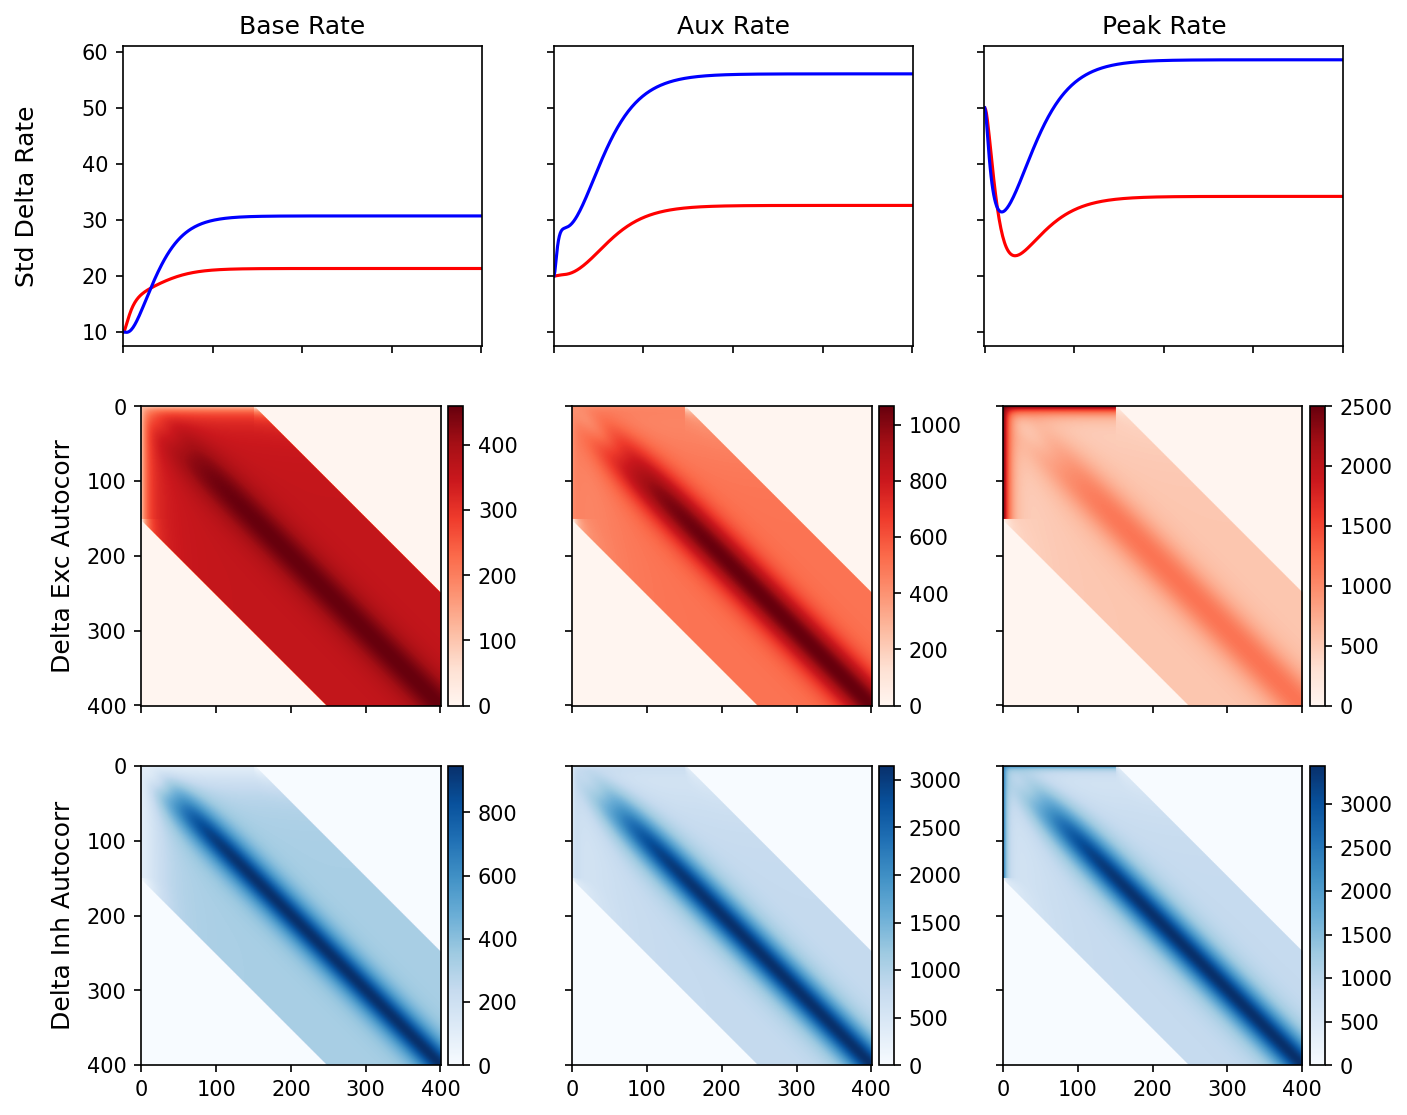

In [144]:
fig,axs = plt.subplots(3,3,figsize=(3.5*3,3*3),dpi=150,sharex=True,sharey='row')

axs[0,0].plot(np.sqrt(np.fmax(np.diag(full_Cdrb[0])-drb[0]**2,0)),'r-')
axs[0,0].plot(np.sqrt(np.fmax(np.diag(full_Cdrb[1])-drb[1]**2,0)),'b-')
axs[0,1].plot(np.sqrt(np.fmax(np.diag(full_Cdra[0])-dra[0]**2,0)),'r-')
axs[0,1].plot(np.sqrt(np.fmax(np.diag(full_Cdra[1])-dra[1]**2,0)),'b-')
axs[0,2].plot(np.sqrt(np.fmax(np.diag(full_Cdrp[0])-drp[0]**2,0)),'r-')
axs[0,2].plot(np.sqrt(np.fmax(np.diag(full_Cdrp[1])-drp[1]**2,0)),'b-')

imshowbar(fig,axs[1+0,0],full_Cdrb[0],cmap='Reds')
imshowbar(fig,axs[1+1,0],full_Cdrb[1],cmap='Blues')
imshowbar(fig,axs[1+0,1],full_Cdra[0],cmap='Reds')
imshowbar(fig,axs[1+1,1],full_Cdra[1],cmap='Blues')
imshowbar(fig,axs[1+0,2],full_Cdrp[0],cmap='Reds')
imshowbar(fig,axs[1+1,2],full_Cdrp[1],cmap='Blues')

axs[0,0].set_title('Base Rate')
axs[0,1].set_title('Aux Rate')
axs[0,2].set_title('Peak Rate')

ytitle(axs[0,0],'Std Delta Rate',xloc=-0.3,fontsize=12)
ytitle(axs[1+0,0],'Delta Exc Autocorr',xloc=-0.3,fontsize=12)
ytitle(axs[1+1,0],'Delta Inh Autocorr',xloc=-0.3,fontsize=12)

In [134]:
print(drb)
print(dra)
print(drp)
print(grid_stat(np.mean,Cdrb[:,:],1,dt))
print(grid_stat(np.mean,Cdra[:,:],1,dt))
print(grid_stat(np.mean,Cdrp[:,:],1,dt))
print(grid_stat(np.mean,sCdr[:,:],1,dt))
print(convdb)
print(convda)
print(convdp)

[-2.0405827 -2.0139275]
[-1.918045  -1.6181068]
[-1.5927048 -1.5889626]
[373.13646655 407.32434429]
[ 602.61482412 1136.68835816]
[ 645.72995098 1235.55566402]
[25.34219748 29.59130058]
[ True  True]
[ True  True]
[ True  True]


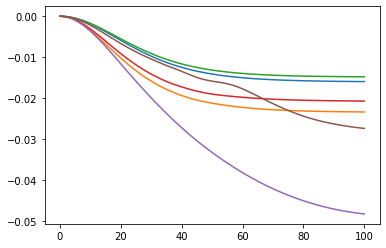

In [143]:
plt.plot((sCr/sCr[:,0:1]-1).T)
plt.plot((sCdr/sCdr[:,0:1]-1).T)

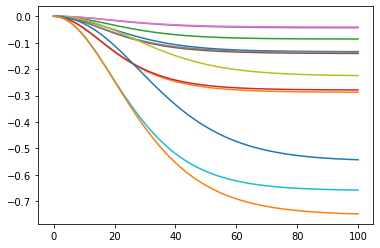

In [145]:
plt.plot((Crb/Crb[:,0:1]-1).T)
plt.plot((Crp/Crp[:,0:1]-1).T)
plt.plot((Cdrb/Cdrb[:,0:1]-1).T)
plt.plot((Cdrp/Cdrp[:,0:1]-1).T)